In [0]:
import warnings  
from time import sleep
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os   
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras import optimizers

In [144]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
train_path = '/content/drive/My Drive/Image_Classification/10_categories_v1'   # Train data path
classes = os.listdir(train_path)                          # List of directories in train path
print(classes)

['BACKGROUND_Google', 'Faces_easy', 'car_side', 'airplanes', 'Leopards', 'bonsai', 'Motorbikes', 'Faces', 'grand_piano', 'watch']


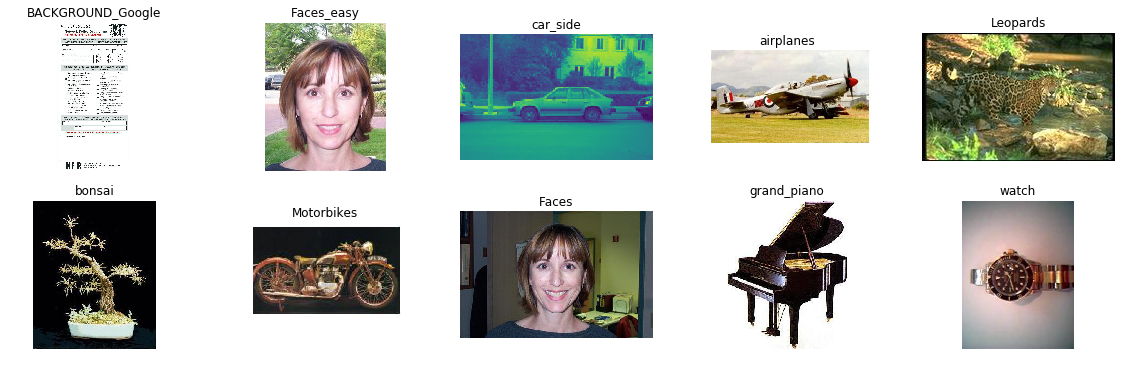

In [146]:
# Plot a sample image from each category

plt.figure(figsize=(20,6))
for ix,i in enumerate(classes):
    f = os.listdir(os.path.join(train_path,i))[80]
    img = mpimg.imread(os.path.join(train_path,i,f))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)

In [147]:
generator = ImageDataGenerator(validation_split=0.3)

train_gen = generator.flow_from_directory(train_path,subset='training',target_size=(224,224))
val_gen = generator.flow_from_directory(train_path,subset='validation',target_size=(224,224))

Found 2635 images belonging to 10 classes.
Found 1124 images belonging to 10 classes.


In [148]:
#For finding "steps_per_epoch" in training and validation
print('',2635/32)
print('',1124/32)

 82.34375
 35.125


In [0]:
# Import ImageDataGenerator for image preprocessing/augmentation
# This basically creates rotating, zooming in, flipping, shifting(adding noise). 
# This includes rotating, zooming in, flipping, shifting, etc.

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') # 'nearest' is kind of algorithm to fill pixel values while transformation

In [0]:
aug_images_path = 'preview'
f = os.listdir(os.path.join(train_path,classes[7]))[0]
img_path = os.path.join(train_path,classes[7],f)
img = load_img(img_path)       # this is a PIL image
x = img_to_array(img)          # this is a Numpy array with shape (480, 640, 3)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 480, 640, 3)

# Create a directory named 'preview' to save augmented images. 
# Delete, if already exists
if os.path.isdir(aug_images_path):
#     os.system('rm -rf '+aug_images_path)
    shutil.rmtree(aug_images_path)
    
os.system('mkdir '+aug_images_path)
    
# the .flow() command below generates augmented images and saves them to a directory names 'preview'
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir=aug_images_path, save_prefix='c0', save_format='jpg'):
    i += 1
    if i > 9:
        break  # otherwise the generator would loop indefinitely

Text(0.5, 1.0, 'Original Image: image_0001.jpg')

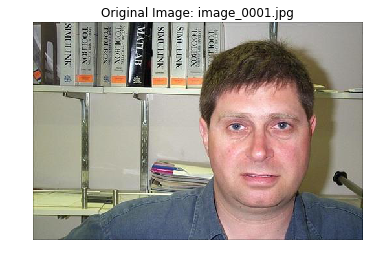

In [151]:
plt.imshow(img)
plt.axis('off')
plt.title('Original Image: '+f)

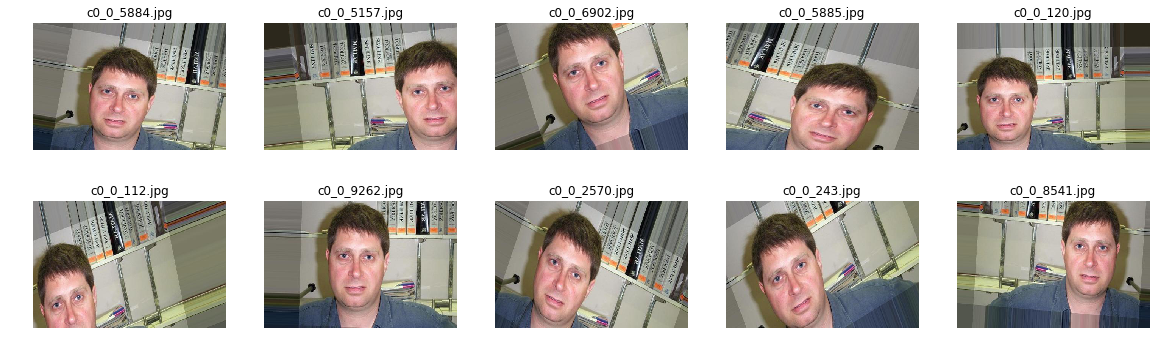

In [152]:
# Plot the augmented images for the above original image
# Read them from 'preview' directory and display them

plt.figure(figsize=(20,6))
aug_images = os.listdir('preview')
for ix,i in enumerate(aug_images):
    img = mpimg.imread(os.path.join('preview',i))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    if ix==500:
        break

In [0]:
# # This is the augmentation configuration we will use for training
# train_datagen = ImageDataGenerator(rescale=1/255.,
#                                     rotation_range=20,
#                                     height_shift_range=0.2,
#                                     zoom_range=0.2)

# # This is a generator that will read pictures found in subfolers of 'train', and generates
# # batches of augmented image data on the fly
# train_generator = train_datagen.flow_from_directory(directory=train_path, 
#                                                     batch_size=64, 
#                                                     class_mode='categorical', 
#                                                     shuffle=True, 
#                                                     target_size=(224,224))

**CNN for Image Classification**

In [0]:
# Sequential is a container in keras which is used to stack layers in order
# First layer should include the input data shape. This is mandatory. 
# Padding valid implies no padding
# Padding SAME implies enough padding so that output has the same dimensions as input 
# Initial layers identify fewer basic features like edges while later layers identify a lot of more abstract features. 
# Therefore, no. of filters increase as we go deeper into the network. 
# Batchormalization is standard in convolution layers. Improves the convergence time.
# Activation is applied after the Batch normalization
# Dropout could be used for regularization in the fully-connected part of the network

def image_classifier(nb_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=(224, 224, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(128, init='uniform', activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return(model)

In [0]:
# Cross Entropy is the standard loss function for classification tasks. 
# Adam is the most popular optimizer. Convergence is quick. Could be unstable sometimes. 
# Learning Rate Schedulers could be used for stabilizing training process
# The 'metrics' mentioned will be computed during run time. So that we can monitor the progress.

model = image_classifier(nb_classes=10)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [0]:
##Need to check and implement

nb_epochs = 20
init_lr = 0.001
min_lr = 0.000001
f = 10**(np.log10(min_lr/init_lr)/float(nb_epochs))

def poly_decay(epoch):
    ''' This function takes the current epoch as input and return the updated learning rate.
        The learning rate is multiplied by a factor 'f' after each epoch.
        In the first epoch, learning rate is set to 'init_lr'.
        By the end of 'nb_epochs' the learning rate is reduced to 'min_lr' '''
    return(init_lr*(f**epoch))

# ModelCheckpoint monitors the 'val_loss' and saves the model graph and weights at the epoch with least 'val_loss'
# 'save_weights_only'=True, saves only the weights
# 'save_weights_only'=False, saves the weights and the graph
chkp = ModelCheckpoint(filepath='inception_dd.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)
lr_schedule = LearningRateScheduler(poly_decay)

In [157]:
# # model.fit returns the history of loss and metrics for train and validation datasets.

hist0 = model.fit_generator(train_gen, steps_per_epoch = 82, 
                           validation_data=val_gen,  validation_steps = 35,
                           epochs=20).history

Epoch 1/20
82/82 [==============================] - 67s 820ms/step - loss: 8.2661 - acc: 0.4729 - val_loss: 11.1317 - val_acc: 0.3036
Epoch 2/20
82/82 [==============================] - 14s 169ms/step - loss: 7.1633 - acc: 0.5429 - val_loss: 14.0812 - val_acc: 0.1264
Epoch 3/20
82/82 [==============================] - 14s 170ms/step - loss: 7.4501 - acc: 0.5265 - val_loss: 10.0406 - val_acc: 0.3736
Epoch 4/20
82/82 [==============================] - 14s 170ms/step - loss: 6.0035 - acc: 0.6151 - val_loss: 11.2285 - val_acc: 0.2995
Epoch 5/20
82/82 [==============================] - 14s 170ms/step - loss: 5.3072 - acc: 0.6614 - val_loss: 8.4685 - val_acc: 0.4679
Epoch 6/20
82/82 [==============================] - 14s 165ms/step - loss: 5.4909 - acc: 0.6518 - val_loss: 8.9403 - val_acc: 0.4368
Epoch 7/20
82/82 [==============================] - 14s 166ms/step - loss: 5.0077 - acc: 0.6793 - val_loss: 5.1872 - val_acc: 0.6703
Epoch 8/20
82/82 [==============================] - 14s 169ms/ste

**Transfer Learning**

In [0]:
# Get Inception architecture from keras.applications
from keras.applications.inception_v3 import InceptionV3

def inception_tl(nb_classes, freez_wts):
    
    trained_model = InceptionV3(include_top=False,weights='imagenet')
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    pred_inception= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_inception)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    return(model)

In [159]:
model = inception_tl(nb_classes=10, freez_wts=False)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
hist1 = model.fit_generator(train_gen, steps_per_epoch = 82,   
                           validation_data=val_gen, validation_steps = 35, 
                           epochs=13).history

Epoch 1/13
82/82 [==============================] - 97s 1s/step - loss: 0.3946 - acc: 0.8990 - val_loss: 1.9835 - val_acc: 0.6218
Epoch 2/13
82/82 [==============================] - 28s 338ms/step - loss: 0.1522 - acc: 0.9608 - val_loss: 1.3404 - val_acc: 0.7299
Epoch 3/13
82/82 [==============================] - 28s 337ms/step - loss: 0.1701 - acc: 0.9528 - val_loss: 1.6844 - val_acc: 0.5742
Epoch 4/13
82/82 [==============================] - 28s 335ms/step - loss: 0.1489 - acc: 0.9552 - val_loss: 1.1934 - val_acc: 0.7179
Epoch 5/13
82/82 [==============================] - 28s 337ms/step - loss: 0.0881 - acc: 0.9783 - val_loss: 0.5103 - val_acc: 0.8397
Epoch 6/13
82/82 [==============================] - 28s 337ms/step - loss: 0.0766 - acc: 0.9772 - val_loss: 0.2027 - val_acc: 0.9414
Epoch 7/13
82/82 [==============================] - 28s 337ms/step - loss: 0.0618 - acc: 0.9837 - val_loss: 0.1484 - val_acc: 0.9661
Epoch 8/13
82/82 [==============================] - 27s 335ms/step - los

Text(0.5, 1.0, 'Accuracy')

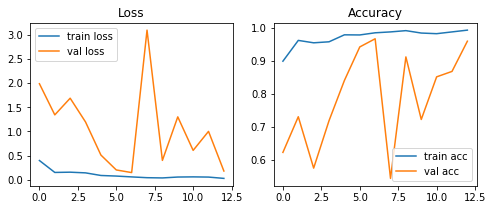

In [160]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
train_loss = plt.plot(hist1['loss'], label='train loss')
val_loss = plt.plot(hist1['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(hist1['acc'], label='train acc')
val_loss = plt.plot(hist1['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')

Learning Rate

In [0]:
model = inception_tl(nb_classes=10, freez_wts=False)
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)

In [0]:
nb_epochs = 10
init_lr = 0.001
min_lr = 0.000001
f = 10**(np.log10(min_lr/init_lr)/float(nb_epochs))

def poly_decay(epoch):
    ''' This function takes the current epoch as input and return the updated learning rate.
        The learning rate is multiplied by a factor 'f' after each epoch.
        In the first epoch, learning rate is set to 'init_lr'.
        By the end of 'nb_epochs' the learning rate is reduced to 'min_lr' '''
    return(init_lr*(f**epoch))

# ModelCheckpoint monitors the 'val_loss' and saves the model graph and weights at the epoch with least 'val_loss'
# 'save_weights_only'=True, saves only the weights
# 'save_weights_only'=False, saves the weights and the graph
chkp = ModelCheckpoint(filepath='inception_dd.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)
lr_schedule = LearningRateScheduler(poly_decay)

Text(0.5, 1.0, 'Learning Rate over Epochs')

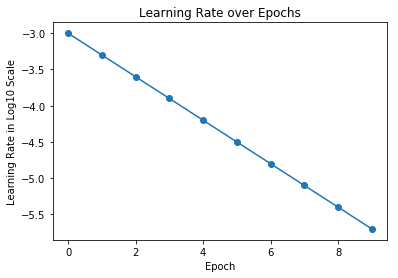

In [163]:
lr_list = [poly_decay(i) for i in range(nb_epochs)]
plt.scatter(range(nb_epochs), np.log10(lr_list))
plt.plot(np.log10(lr_list))
plt.xlabel('Epoch')
plt.ylabel('Learning Rate in Log10 Scale')
plt.title('Learning Rate over Epochs')

In [164]:
hist = model.fit_generator(train_gen, steps_per_epoch = 82, 
                           validation_data=val_gen,  validation_steps = 35,
                           epochs=nb_epochs, 
                           callbacks=[chkp, lr_schedule]).history
#np.savez('inception_dd_history.npz', loss=hist['categorical_crossentropy'], acc=hist['acc'], val_loss=hist['val_loss'], val_acc=hist['val_acc'])

Epoch 1/10
82/82 [==============================] - 143s 2s/step - loss: 0.4198 - acc: 0.8751 - val_loss: 4.2540 - val_acc: 0.5852
Epoch 2/10
82/82 [==============================] - 28s 340ms/step - loss: 0.1538 - acc: 0.9570 - val_loss: 0.1554 - val_acc: 0.9625
Epoch 3/10
82/82 [==============================] - 28s 344ms/step - loss: 0.0431 - acc: 0.9882 - val_loss: 0.0879 - val_acc: 0.9716
Epoch 4/10
82/82 [==============================] - 28s 344ms/step - loss: 0.0236 - acc: 0.9932 - val_loss: 0.0693 - val_acc: 0.9863
Epoch 5/10
82/82 [==============================] - 28s 341ms/step - loss: 0.0121 - acc: 0.9970 - val_loss: 0.0535 - val_acc: 0.9826
Epoch 6/10
82/82 [==============================] - 28s 341ms/step - loss: 0.0148 - acc: 0.9943 - val_loss: 0.0498 - val_acc: 0.9863
Epoch 7/10
82/82 [==============================] - 28s 342ms/step - loss: 0.0104 - acc: 0.9970 - val_loss: 0.0474 - val_acc: 0.9866
Epoch 8/10
82/82 [==============================] - 28s 341ms/step - lo

Text(0.5, 1.0, 'Accuracy')

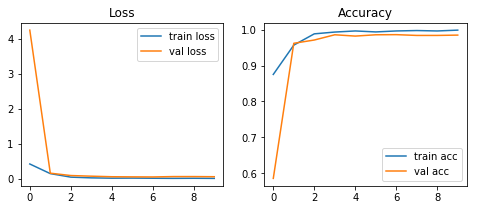

In [165]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
train_loss = plt.plot(hist['loss'], label='train loss')
val_loss = plt.plot(hist['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(hist['acc'], label='train acc')
val_loss = plt.plot(hist['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')

Predictions

In [166]:
steps = 1124 / 32
predictions = model.predict_generator(val_gen, steps=steps)

len(predictions)

1124

In [167]:
val_preds = model.predict_generator(generator=val_gen, steps = steps,verbose=1)
len(val_preds)

36/35 [==============================] - 5s 133ms/step


1124

In [168]:
predictions.argmax(axis=-1)

array([3, 0, 2, ..., 6, 5, 4])

In [169]:
len(val_gen.classes)

1124

In [170]:
val_gen.classes[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [0]:
#len(val_preds_class)

In [172]:
val_preds_class = predictions.argmax(axis=-1)
val_preds_df = pd.DataFrame([val_gen.filenames, val_preds_class])
val_preds_df = pd.DataFrame({'image':val_gen.filenames, 'prediction':val_preds_class})
val_preds_df.head(10)

,image,prediction
0,BACKGROUND_Google/image_0001.jpg,3
1,BACKGROUND_Google/image_0002.jpg,0
2,BACKGROUND_Google/image_0003.jpg,2
3,BACKGROUND_Google/image_0004.jpg,2
4,BACKGROUND_Google/image_0005.jpg,4
5,BACKGROUND_Google/image_0006.jpg,9
6,BACKGROUND_Google/image_0007.jpg,3
7,BACKGROUND_Google/image_0008.jpg,6
8,BACKGROUND_Google/image_0009.jpg,8
9,BACKGROUND_Google/image_0010.jpg,4


In [173]:
val_gen.class_indices

{'BACKGROUND_Google': 0,
 'Faces': 1,
 'Faces_easy': 2,
 'Leopards': 3,
 'Motorbikes': 4,
 'airplanes': 5,
 'bonsai': 6,
 'car_side': 7,
 'grand_piano': 8,
 'watch': 9}